# NSDUH Drug Sequence Analysis Part 6:  Exploring Stable Clusters
## Matthew J. Beattie
## University of Oklahoma
__February 10, 2021__

### Stability Clusters Exploration
Step 5 showed the relationship between the number of connected components in the graphs and the stability of the edges included in the graphs.  We also determined an optimal stability point to generate the clusters:  $c=13, \alpha=0.60$

### Approach
* Read in the connected components file
* Explore sizes of connected components

In [1]:
"""
Import python modules
"""
import pandas as pd
import numpy as np
import copy
import os
import sys
import pathlib, itertools
import time
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import random
import pickle
import json
import pathutils as pu
import mlflow
import profile
import gc
import csv
from math import dist, sqrt

HOME_DIR = pathlib.Path.home()
CW_DIR = pathlib.Path.cwd()

FIGW = 12
FIGH = 5
FONTSIZE = 8
FIGURESIZE = (FIGW,FIGH)

plt.rcParams['figure.figsize'] = (FIGW, FIGH)
plt.rcParams['font.size'] = FONTSIZE

plt.rcParams['xtick.labelsize'] = FONTSIZE
plt.rcParams['ytick.labelsize'] = FONTSIZE


### Set file names, etc.

In [2]:
# Set working parameters
datapath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Data3/'
workingpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Code3/'
outpath = 'C:/Users/mjbea/OneDrive/GitHub/abuse_sequence/Output3/'
hugefiles = 'C:/Users/mjbea/huge_files/'
year = '2016_2017_2018_2019'
jsondict = datapath + 'NSDUH_field.json'
n_clusters = 13
alpha = 0.60

# Setup filenames
compcsv = outpath + 'conncomp13.csv'
compsizecsv = outpath + 'conncompsize13.csv'
newcompcsv = outpath + 'conncompnewlabel13.csv'
jsonfile2 = outpath + 'stableclusts_' + str(n_clusters) + '_stab_' + str(alpha) + '_stats.json'
newdfpkl = datapath + 'stableclusts_' + str(n_clusters) + '_stab_' + str(alpha) + '_alldata.pkl'

# Get translation dictionaries
stryear = '2016_2017_2018_2019'

# Drug name and indices are called by a user-defined function.
ident, rawafuvals, afuvals, drugnames, drugorder, drugnums, drugposition, startdemog, demographics = pu.surveyvars(year)

# Decode dictionaries for NSDUH variables:
f1 = open(jsondict, 'r')
nsduhDecoder = json.load(f1)
f1.close()


### Helper Utilities
These methods calculate cluster stats such as inertia, average inertia, center of cluster, and nearest medoid to center, and a descriptive AFU path that characterizes the medoid.

In [3]:

"""
getcenter(df)
Calculates and returns the center and inertia of a cluster.  Uses weights from survey.
"""
def getcenter(df):
    df['AFUARRAY'] = df.apply(lambda row: np.matrix(row['AFUVECT']).A[0],axis=1)
    center = np.average(a=df['AFUARRAY'], weights=df['YRWEIGHT'])
    df['DISTSQ'] = df.apply(lambda row: euclidean(row['AFUARRAY'],center)**2, axis=1)
    df['WTDISTSQ'] = df.apply(lambda row: row['DISTSQ'] * row['YRWEIGHT'], axis=1)
    inertia = df['WTDISTSQ'].sum()
    return center, inertia


"""
getmedoid(df)
Calculates and returns medoid of a cluster
"""
def getmedoid(df, clustcenter):
#    clustcenter, clustinertia = getcenter(df)
    df['distfrommean'] = df.apply(lambda row: euclidean(np.matrix(row['AFUVECT']).A[0], clustcenter), axis=1)
    medoidstr = df.loc[df['distfrommean'].idxmin()]['AFUVECT']
    medoid = np.matrix(medoidstr).A[0]
    return medoid


"""
arrayToPath(medoid)
Converts a medoid to a path list
"""
def arrayToPath(array):
    afupath = {}
    i = 0
    for item in array:
        pathstep = {drugposition[i]: float(item)}   # The type conversion is necessary for saving in JSON
        if item != 991:
            afupath.update(pathstep)
        i += 1
    return afupath


In [4]:
# Read in connected components file
dfconncomps = pd.read_csv(compcsv, sep='\t', dtype={'id': str, 'YRWEIGHT': np.float64, 'CATAG6': np.int64,
                           'SVCFLAG': np.int64, 'IRSEX': np.int64, 'IRMARIT': np.int64, 'NEWRACE2': np.int64,
                          'EDUHIGHCAT': np.int64, 'IRWRKSTAT': np.int64, 'GOVTPROG': np.int64, 'INCOME': np.int64,
                          'COUTYP4': np.int64, 'AIIND02': np.int64, 'component': np.int64, 'AFUVECT': object})
dfconncomps

,id,YRWEIGHT,CATAG6,SVCFLAG,IRSEX,IRMARIT,NEWRACE2,EDUHIGHCAT,IRWRKSTAT,GOVTPROG,INCOME,COUTYP4,AIIND02,component,AFUVECT
0,201647492896.0,813.43780,4,0,1,1,1,3,1,2,3,3,2,26,"[0,19,14,14,22,19,15,16,991,991]"
1,201648315633.0,2629.29900,2,0,2,4,1,2,4,1,2,1,2,3,"[0,13,18,15,22,33,991,991,991,991]"
2,201689079659.0,903.90880,3,0,1,4,2,3,1,2,4,1,2,3,"[0,15,21,991,991,991,991,991,991,991]"
3,201884007486.0,643.19710,2,0,1,4,2,1,3,1,2,2,2,3,"[0,19,19,991,991,991,991,991,991,991]"
4,201942158995.0,2068.38180,2,0,1,4,1,2,1,2,4,3,2,3,"[0,18,16,991,991,991,991,991,991,991]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51278,201925516365.0,749.87960,4,0,2,3,7,3,1,2,2,3,2,0,"[0,991,991,991,991,991,991,991,991,991]"
51279,201627070980.0,213.76172,2,0,1,4,7,3,1,2,2,2,2,0,"[0,991,991,991,991,991,991,991,991,991]"
51280,201683929574.0,256.74725,3,0,1,4,1,3,1,2,2,3,2,3,"[0,20,21,991,991,991,991,991,991,991]"
51281,201731417485.0,1370.53040,4,0,1,4,2,1,4,1,1,2,2,0,"[0,991,991,991,991,991,991,991,991,991]"


In [5]:
# Relabel components in order of size
counts = pd.DataFrame(dfconncomps.drop(columns=['CATAG6','SVCFLAG','IRSEX','IRMARIT',
                                  'NEWRACE2','EDUHIGHCAT','IRWRKSTAT','GOVTPROG',
                                  'INCOME','COUTYP4','AIIND02','AFUVECT']).groupby(['component']).sum('YRWEIGHT'))
counts = counts.rename(columns={'YRWEIGHT':'compcount'}).sort_values(by='compcount',ascending=False)
counts['newlabel'] = counts.reset_index().index
counts.to_csv(compsizecsv)

# Join the new component labels back into the connected components dataframe and save as a CSV and pickle
newdf = dfconncomps.join(counts, on=['component'], how='inner').drop(columns=['compcount'])
newdf.to_csv(newcompcsv,sep='\t')
newdf.to_pickle(newdfpkl)

In [6]:
newdf

,id,YRWEIGHT,CATAG6,SVCFLAG,IRSEX,IRMARIT,NEWRACE2,EDUHIGHCAT,IRWRKSTAT,GOVTPROG,INCOME,COUTYP4,AIIND02,component,AFUVECT,newlabel
0,201647492896.0,813.43780,4,0,1,1,1,3,1,2,3,3,2,26,"[0,19,14,14,22,19,15,16,991,991]",4
12,201857071414.0,159.80916,4,0,1,4,3,2,4,2,1,3,1,26,"[0,10,12,12,19,991,19,10,991,25]",4
74,201681126523.0,2904.60800,3,0,1,4,1,2,1,1,2,1,2,26,"[0,8,3,8,8,42,13,16,18,991]",4
90,201984186563.0,586.73040,2,0,1,3,7,3,1,2,3,1,2,26,"[0,10,14,10,14,27,11,13,991,13]",4
99,201813423565.0,674.53644,2,0,2,4,1,1,1,2,1,2,2,26,"[0,11,15,13,18,36,18,18,18,19]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47834,201941287554.0,3932.01600,5,0,2,1,1,3,4,2,3,2,2,34359738470,"[0,16,16,15,991,42,15,991,991,15]",11
49045,201830120309.0,332.88562,2,0,2,4,1,3,2,2,2,2,1,34359738470,"[0,12,14,14,991,29,13,991,991,18]",11
49196,201834398876.0,603.77650,3,0,1,4,1,1,4,2,1,3,2,34359738470,"[0,16,15,10,991,33,15,991,991,26]",11
51195,201927755496.0,1334.98290,4,0,2,1,1,3,2,2,4,1,2,34359738470,"[0,18,16,18,991,26,19,991,991,19]",11


In [7]:
counts

,compcount,newlabel
component,,
3,2.205231e+07,0
1,1.470119e+07,1
13,1.290954e+07,2
0,7.976612e+06,3
26,3.990358e+06,4
17,3.518058e+06,5
40,2.925195e+06,6
5,2.207413e+06,7
2,1.958418e+06,8


In [8]:
clust0 = newdf[newdf.newlabel==0]

In [9]:
clust0['AFUARRAY'] = clust0.apply(lambda row: np.matrix(row['AFUVECT']).A[0],axis=1)
center = np.average(a=clust0['AFUARRAY'], weights=clust0['YRWEIGHT'])
#    center = np.average(a=df['AFUARRAY'])
center

C:\Users\mjbea\anaconda3\envs\py38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


array([  0.        ,  20.35631777,  20.77586485, 706.83989741,
       850.14079742, 908.49300257, 835.93211806, 949.2938753 ,
       984.333117  , 964.79188742])

In [10]:
clust0['AFUARRAY'] = clust0.apply(lambda row: np.matrix(row['AFUVECT']).A[0],axis=1)
center = np.average(a=clust0['AFUARRAY'])
center

array([  0,  21,  20, 667, 859, 882, 786, 943, 983, 963])

### Cluster Size and Characteristics
Determine cluster sizes for $\alpha=0.60$ connected components group.  Find the centers and medoids for the clusters and store into a JSON file.

C:\Users\mjbea\anaconda3\envs\py38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


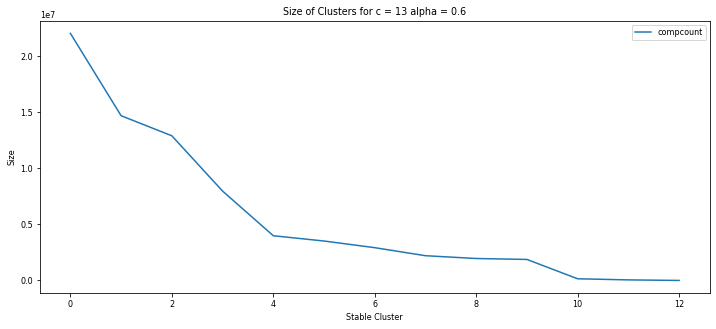

In [11]:
 # Setup an MLFlow experiment
experiment_name = 'Stable Connected Component Size'
mlflow.set_experiment(experiment_name)

# Carryover parameters for the run
B = 20
fraction = .30
f = 0.8
n_init = 10
max_iter = 1000
tol = 0.0001

with mlflow.start_run():
    mlflow.log_param("Number of cluster sets", B)
    mlflow.log_param("Fraction of total data used", fraction)
    mlflow.log_param("Sub-fraction used for cluster folds", f)
    mlflow.log_param('Number of KNN runs', n_init)
    mlflow.log_param('Maximum KNN iterations', max_iter)
    mlflow.log_param('KNN tolerance', tol)
    mlflow.log_param("Edge stability", alpha)
    mlflow.log_param("Number of stable clusters", n_clusters)
    mlflow.log_artifact(compsizecsv)

    # Plot cluster sizes
    size_title = 'Size of Clusters for c = ' + str(n_clusters) + ' alpha = ' + str(alpha)
    size_picfile = outpath + 'stableclusts_' + str(n_clusters) + '_stab_' + str(alpha) + '_clustsize.png'

    fig = counts.plot(x='newlabel', y='compcount')
    plt.xlabel('Stable Cluster')
    plt.ylabel('Size')
    plt.title(size_title)
    plt.savefig(size_picfile)
    
    mlflow.log_artifact(size_picfile)
    
    # Characterize clusters and save to json
    clustcount = max(newdf['newlabel'] + 1)
    jsonfile2 = outpath + 'stableclusts_' + str(n_clusters) + 'clust_' + str(alpha) + 'stab.json'

    tempdict = {}
    population = newdf['YRWEIGHT'].sum()

    # Build dictionary of clusters
    for index in range(0,clustcount):
        clust = newdf.loc[newdf['newlabel'] == index,:]
        clustpop = clust['YRWEIGHT'].sum()
        numnodes = clust.shape[0]
        center, inertia = getcenter(clust)
        medoid = getmedoid(clust, center)
        medoidpath = arrayToPath(medoid)
        centerpath = arrayToPath(center)
        tempdict.update({index: {'totalpop': population, 'size': clustpop, 'center': center.tolist(), 'centerpath': centerpath,
                                 'medoid': medoid.tolist(), 'medoidpath': medoidpath, 'avginertia': inertia/clustpop,
                                 'clustfrac': round(clustpop/population,5)}})

    # Save cluster dictionary to json file
    with open(jsonfile2,'w') as cluststats_dumped:
        json.dump(tempdict,cluststats_dumped,indent = 4,sort_keys = True)
        
    mlflow.log_artifact(jsonfile2)

 
mlflow.end_run()
